In [50]:
import os
import nltk

import math

import matplotlib.pyplot as plt


from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from community import community_louvain
from fa2 import ForceAtlas2

In [7]:
# Create character tuple list
import csv
import os

characters = []

with open("HP_characters.csv", "r", encoding="utf8") as sent_file:
    csv = csv.reader(sent_file, delimiter=",")
    for row in csv:
        name = row[0].replace(' ', '_')
        parentage = row[1]
        house = row[2]
        occupation = row[3]
        characters.append((name, parentage, house, occupation))

In [8]:
# Confirm that we have a file for each character in our list
unzipped = list(list(zip(*characters))[0])
names = []

for file in os.listdir("characters"):
    names.append(file[:-4])

# The difference between the sets is the empty set
print(set(unzipped) - set(names))

set()


In [9]:
import os
import re
import networkx as nx

# Init graph
G = nx.DiGraph()

# Insert nodes
for character in characters:
    G.add_node(character[0], parentage=character[1], house=character[2], occupation=[3])
    
for file in os.listdir("characters"):
    orig_character = file[:-4]
    
    link_list = []
    fileopener = open("characters/" + file, 'r')
    text = fileopener.read()    
    links = re.findall(r'[[]{2}.*?[]]{2}', text)
        
    for link in links:
        character = link.replace("[", "").replace("]", "").replace(" ", "_")
        character = character.partition("|")[0]
        link_list.append(character)
    link_list = [*set(link_list)]
    
    for character in link_list:
        filename = character + ".txt"
        if os.path.isfile("characters/" + filename) or os.path.isfile("characters/" + filename):
            G.add_edge(orig_character, character)

print("Number of nodes: " + str(G.number_of_nodes()))
print("Number of edges: " + str(G.number_of_edges()))

Number of nodes: 339
Number of edges: 6193


sum in_degrees = 6193
sum out_degrees = 6193


Text(0.5, 1.0, 'In- and out-degrees')

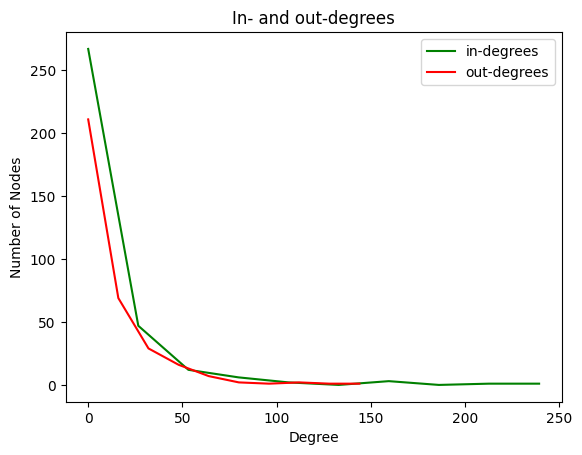

In [16]:
import numpy as np
import matplotlib.pyplot as plt

in_degrees = [i for (c, i) in G.in_degree]
out_degrees = [o for (c, o) in G.out_degree]

print(f"sum in_degrees = {sum(in_degrees)}")
print(f"sum out_degrees = {sum(out_degrees)}")

in_counts, in_bins = np.histogram(in_degrees)
out_counts, out_bins = np.histogram(out_degrees)

plt.plot(in_bins[:-1], in_counts, color = 'green', label='in-degrees')
plt.plot(out_bins[:-1], out_counts, color = 'red', label = 'out-degrees')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('In- and out-degrees')

## Communities

In [20]:
# Making the graph undirected for the plotting
uG = G.to_undirected()

nodes = list(uG.nodes)
degrees = [d for (n,d) in list(uG.degree)]

100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 526.32it/s]


BarnesHut Approximation  took  0.91  seconds
Repulsion forces  took  2.48  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


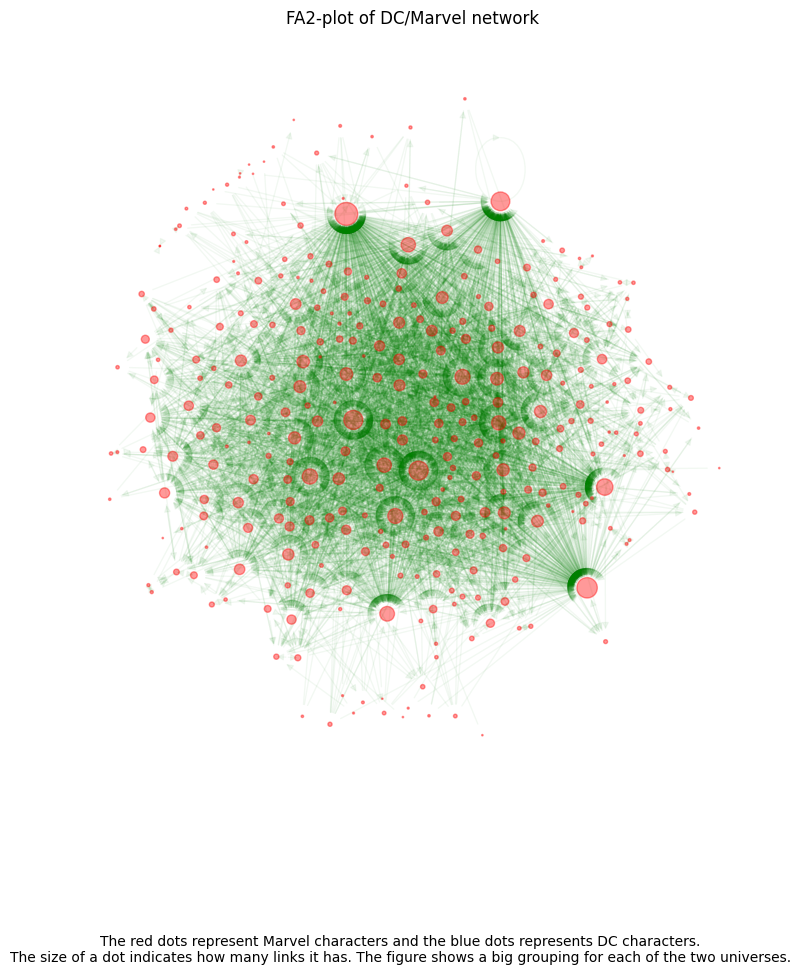

In [26]:
# Adjusting figure size
plt.rcParams['figure.figsize'] = [10, 10]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2, # original 1.2
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=0.1, # original 0.5

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, nodelist = nodes, node_size=degrees, node_color="red", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.title('FA2-plot of DC/Marvel network')
plt.figtext(.5, -0.05, f"The red dots represent Marvel characters and the blue dots represents DC characters.\nThe size of a dot indicates how many links it has. The figure shows a big grouping for each of the two universes.", ha="center")

plt.show()

In [30]:
partition = community_louvain.best_partition(uG)

In [31]:
partition_list = []
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    partition_list.append(list_nodes)
partition_list = sorted(partition_list, key=len, reverse=True)

100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 276.81it/s]


BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  5.57  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.36  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


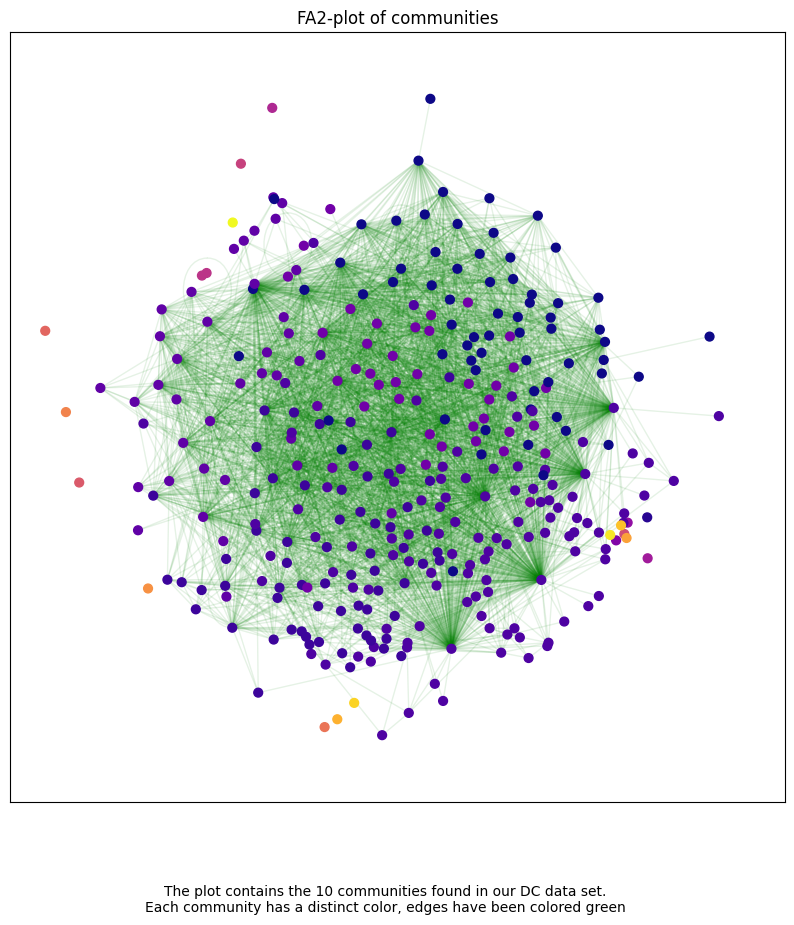

In [34]:
# Adjusting figure size
plt.rcParams['figure.figsize'] = [10, 10]

#drawing using ForceAtlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.1,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.5, # original 0.5
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10.0,
                        strongGravityMode=True,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(uG, pos=None, iterations=2000)
cmap = plt.get_cmap('plasma', max(partition.values()) + 1)

nx.draw_networkx_nodes(uG, positions, partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(uG, positions, edge_color='green', alpha=0.1)
plt.title('FA2-plot of communities')
plt.figtext(.5, 0, f"The plot contains the 10 communities found in our DC data set.\nEach community has a distinct color, edges have been colored green", ha="center")
plt.show()


In [43]:
#Putting together the text from the pages belonging to each community
community_texts = []
maxrange = 0
#if we have less than 10 communities
if len(partition_list) < 10:
    maxrange = len(partition_list)
else:
    maxrange = 10
    
for sublist in partition_list[:maxrange]:
    com_txt = []
    for character in sublist:
        f = open("./characters/"+character+".txt")
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(BeautifulSoup(raw, 'html.parser').get_text())
        file_text = [w.lower() for w in tokens if w.isalpha()]
        com_txt = com_txt + file_text
    community_texts.append(com_txt)

stopwords = nltk.corpus.stopwords.words('english')

community_strings = []
for txt in community_texts:
    com_words = [w for w in txt if w not in stopwords]
    community_strings.append(com_words)

In [44]:
unique_terms = []
for community_words in community_strings:
    unique_terms.append(list(set(community_words)))

In [45]:
def idf(word, unique_list):
    N = len(unique_list)
    term_appears = 0
    for sublist in unique_list:
        if word in sublist:
            term_appears+=1
    idf_val = math.log(N/(1+term_appears))+1
    return idf_val

In [48]:
# Creating the tf list
tfidf_list = []

for community_words in community_strings:
    fdist = FreqDist(community_words)
    total_terms = len(community_words)
    tfidf=[]
    for word in fdist:
        idf_val = idf(word, unique_terms)
        tf_val = fdist[word]/total_terms
        tfidf_elem=(word, tf_val*idf_val)
        tfidf.append(tfidf_elem)
    tfidf_list.append(tfidf)


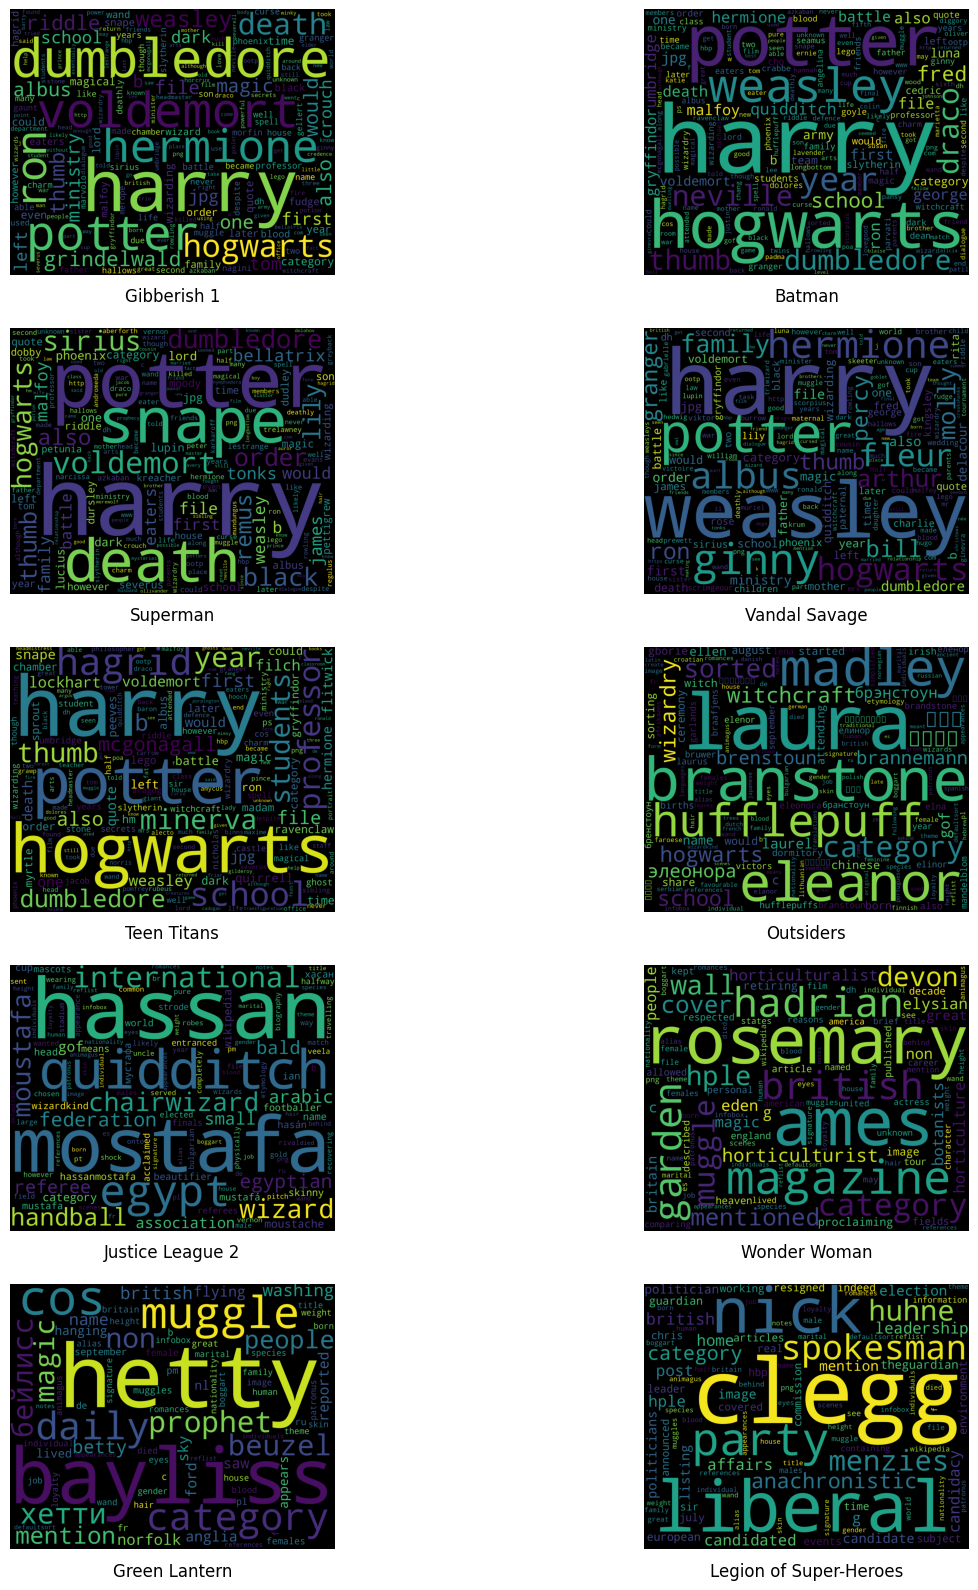

In [51]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15, 20]
captions = ["Gibberish 1",
            "Batman",
            "Superman",
            "Vandal Savage",
            "Teen Titans",
            "Outsiders",
            "Justice League 2",
            "Wonder Woman",
            "Green Lantern",
            "Legion of Super-Heroes"]

for i in range(len(tfidf_list)):
    ax = fig.add_subplot(5,2,i+1)
    wordcloud = WordCloud(background_color='black', width=2200,
                      height=1800, collocations=False).generate_from_frequencies(dict(tfidf_list[i]))

    ax.imshow(wordcloud)
    ax.text(0.5,-0.1, captions[i], size=12, ha="center", 
         transform=ax.transAxes)
    ax.axis('off')
plt.show()